In [19]:
import numpy as np
# import pickle
from tensorflow import keras
from keras.datasets import mnist, cifar10 , fashion_mnist
from keras.models import load_model, Model
from keras.utils import to_categorical
from tensorflow.keras import models
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
from numpy.random import rand, randn

Data

In [2]:
def dataset(data_name, model_name):
  CLIP_MIN = -0.5
  CLIP_MAX = 0.5

  if data_name =="mnist":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    y_test = to_categorical(y_test, 10)
    y_train = to_categorical(y_train, 10)

    # ##Model
    if model_name=="LeNet1":
      model=load_model("./Models/model_mnist_LeNet1.h5")
      last_layer_name = 'flatten'
    elif model_name=="LeNet5":
      model=load_model("./Models/model_mnist_LeNet5.h5")
      last_layer_name = 'activation_13'

  elif data_name == "cifar10":
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    y_test = to_categorical(y_test, 10)
    y_train = to_categorical(y_train, 10)


    if model_name=="resnet20":
      model=load_model("./Models/model_cifar10_resnet20.h5")
      last_layer_name = 'global_average_pooling2d_2'
    elif model_name=="convnet12":
      model = load_model("./Models/model_cifar10_convnet12.h5")
      last_layer_name = 'dropout_3'

  elif data_name == 'fashion_mnist':
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    y_test = to_categorical(y_test, 10)
    y_train = to_categorical(y_train, 10)

    if model_name=="LeNet4":
      model=load_model("./Models/model_fashion_mnist_LeNet4.h5")
      last_layer_name = 'dense'

  # x_train = (x_train / 255.0)
  # x_test = (x_test / 255.0)
  x_train = (x_train / 255.0) - (1.0 - CLIP_MAX)
  x_test = (x_test / 255.0) - (1.0 - CLIP_MAX)

  return x_train, y_train, x_test, y_test, model, last_layer_name

DeepDTS

In [3]:
def getStatistics(last_layer_model, x_train, y_train, model):
    predictions = model.predict(x_train)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_train, axis=1)
    
    # Filter out correctly predicted samples
    correctly_predicted_indices = np.where(predicted_classes == true_classes)[0]
    x_train_true = x_train[correctly_predicted_indices]
    y_train_true = y_train[correctly_predicted_indices]

    last_layer_activations = last_layer_model.predict(x_train_true)

    true_labels_one_hot = y_train_true

    # Convert one-hot encoded labels to class labels
    true_labels = np.argmax(true_labels_one_hot, axis=1)

    # Calculate mean and std for each neuron by class
    num_classes = true_labels_one_hot.shape[1]
    class_means = np.zeros((num_classes, last_layer_activations.shape[1]))
    class_stds = np.zeros((num_classes, last_layer_activations.shape[1]))

    for class_label in range(num_classes):
        # Get indices of samples belonging to the current class
        class_indices = np.where(true_labels == class_label)[0]

        # Extract activations for the current class
        class_activations = last_layer_activations[class_indices]

        # Calculate mean and std for each neuron within the current class
        class_means[class_label] = np.mean(class_activations, axis=0)
        class_stds[class_label] = np.std(class_activations, axis=0)

    return class_means, class_stds

def safe_divide(numerator, denominator, default_value=0):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.true_divide(numerator, denominator)
        result[denominator == 0] = default_value
    return result

def get_neuron_deflection_score(test_data, test_activations, class_means, class_stds):
    # Get penultimate layer activations for the test data

    # Initialize a matrix to store the summed normalized deflections
    num_samples = test_data.shape[0]
    num_classes = class_means.shape[0]
    neuron_deflection_score = np.zeros((num_samples, num_classes))

    # Compute summed normalized deflection for each test sample
    for i, activation in enumerate(test_activations):
        for class_label in range(num_classes):
            deflections = safe_divide(activation - class_means[class_label], class_stds[class_label])

            # Sum the deflections to get a single value per class per test sample
            neuron_deflection_score[i, class_label] = np.sum(np.abs(deflections))

    return neuron_deflection_score

def cluster_and_sort_samples(deflections):
    # Identify the class with the lowest deflection score for each test sample
    predicted_classes = np.argmin(deflections, axis=1)

    # Cluster test samples based on predicted classes
    clusters = {class_id: [] for class_id in range(deflections.shape[1])}
    for i, class_id in enumerate(predicted_classes):
        clusters[class_id].append((i, deflections[i][class_id]))

    # Sort each cluster by the deflection scores of the predicted class
    sorted_clusters = {}
    for class_id, samples in clusters.items():
        sorted_samples = sorted(samples, key=lambda x: x[1], reverse=True)
        sorted_clusters[class_id] = sorted_samples

    return sorted_clusters



Other Test Selection Methods

In [ ]:
def nc_scores(activation_model, x_data, threshold_k):
    activated_neurons_counts = np.zeros(len(x_data))
    batch_size = 32  # Adjust the batch size if necessary

    for i in range(0, len(x_data), batch_size):
        batch = x_data[i:i + batch_size]
        activations = activation_model.predict(batch, verbose=0)

        for j, activation in enumerate(zip(*activations)):
            total_activation = sum(np.sum(act > threshold_k) for act in activation)
            activated_neurons_counts[i + j] = total_activation

    return activated_neurons_counts

def get_maxp_scores(probabilities):
    maxp_scores = 1 - np.max(probabilities, axis=1)
    return maxp_scores

def get_gini_scores(probabilities):
    gini_scores = 1 - np.sum(np.square(probabilities), axis=1)
    return gini_scores

def get_entropy_scores(probabilities):
    entropy_scores = -np.sum(probabilities * np.log(probabilities + 1e-9), axis=1)
    return entropy_scores

Order Inputs Based on Selection Methods

In [7]:
data_name = 'mnist'  # 'mnist' 'cifar10' 'fashion_mnist'
model_name = 'LeNet5' # minst: ['LeNet1' 'LeNet5'],  cifar10 ['resnet20' 'convnet12'], SVHN ['LeNet5'] fashion_mnist ['LeNet4']
x_train, y_train, x_test, y_test, model, last_layer_name = dataset(data_name, model_name)

input_layer = model.input
output_layer = model.get_layer(last_layer_name).output
last_layer_model = models.Model(inputs=input_layer, outputs=output_layer)

class_means, class_stds = getStatistics(last_layer_model, x_train, y_train, model)

predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
test_mispredictions = np.where(predicted_classes != true_classes)[0]

t1 = time.perf_counter()
#DeepDTS
test_activations = last_layer_model.predict(x_test)
deflections = get_neuron_deflection_score(x_test, test_activations, class_means, class_stds)
sorted_clusters = cluster_and_sort_samples(deflections)

t2=time.perf_counter()
print("deepDTS", t2-t1)
#NC
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
threshold_k = 0.75
activated_neurons_counts = nc_scores(activation_model, x_test, threshold_k)
sorted_nc_indices = np.argsort(activated_neurons_counts)[::-1]

t3=time.perf_counter()
print("NC", t3-t2)
#MAXP
maxp_scores = get_maxp_scores(predictions)
sorted_maxp_indices = np.argsort(maxp_scores)[::-1]

t4=time.perf_counter()
print("MAXP, GINI", t4-t3)
#Gini
gini_scores = get_gini_scores(predictions)
sorted_gini_indices = np.argsort(gini_scores)[::-1]

#Entropy
entropy_scores = get_entropy_scores(predictions)
sorted_entropy_indices = np.argsort(entropy_scores)[::-1]


313/313 [==============================] - 0s 1ms/step
deepDTS 0.9721620827913284
NC 6.720029667019844
MAXP, GINI 0.0009200000204145908


Run Experiments

In [8]:
size = 100 # 200, 500, 1000

deepNDS_indices = []
per_cluster_limit = size // len(sorted_clusters)
for cluster in sorted_clusters.values():
    deepNDS_indices.extend([sample[0] for sample in cluster[:per_cluster_limit]])

#Singular Entropy Diversity (SED) Scores
U, S, Vt = np.linalg.svd(test_activations[deepNDS_indices])
S = np.square(S)
normalized_S = S / np.sum(S)
diversity_entropy = -np.sum(normalized_S * np.log(normalized_S))
print("Diversity DeepNDS (Entropy of Singular Values):", diversity_entropy)
U, S, Vt = np.linalg.svd(test_activations[sorted_nc_indices[:size]])
S = np.square(S)
normalized_S = S / np.sum(S)
diversity_entropy = -np.sum(normalized_S * np.log(normalized_S))
print("Diversity NC (Entropy of Singular Values):", diversity_entropy)
U, S, Vt = np.linalg.svd(test_activations[sorted_maxp_indices[:size]])
S = np.square(S)
normalized_S = S / np.sum(S)
diversity_entropy = -np.sum(normalized_S * np.log(normalized_S))
print("Diversity MAXP (Entropy of Singular Values):", diversity_entropy)
U, S, Vt = np.linalg.svd(test_activations[sorted_gini_indices[:size]])
S = np.square(S)
normalized_S = S / np.sum(S)
diversity_entropy = -np.sum(normalized_S * np.log(normalized_S))
print("Diversity GINI (Entropy of Singular Values):", diversity_entropy)
U, S, Vt = np.linalg.svd(test_activations[sorted_entropy_indices[:size]])
S = np.square(S)
normalized_S = S / np.sum(S)
diversity_entropy = -np.sum(normalized_S * np.log(normalized_S))
print("Diversity Entropy (Entropy of Singular Values):", diversity_entropy)


Diversity DeepNDS (Entropy of Singular Values): 0.63473666
Diversity NC (Entropy of Singular Values): 0.20863476
Diversity MAXP (Entropy of Singular Values): 0.43132138
Diversity GINI (Entropy of Singular Values): 0.3613956
Diversity Entropy (Entropy of Singular Values): 0.34253997


Diversity Metric Comparisons

In [15]:
def get_image_indices_for_classes(class_indices, num_images_per_class, y_test):
    indices = []
    for class_index in class_indices:
        class_specific_indices = np.where(y_test == class_index)[0]
        indices.extend(np.random.choice(class_specific_indices, num_images_per_class, replace=False))
    return indices

def calculate_sed(activations):
    U, S, Vt = np.linalg.svd(activations)
    S = np.square(S)
    normalized_S = S / np.sum(S)
    return -np.sum(normalized_S * np.log(normalized_S))


def calculate_gd(activations):
    scaler = MinMaxScaler()
    scaled_activations = scaler.fit_transform(activations)
    h=np.dot(scaled_activations,scaled_activations.T)
    _, Ldet=np.linalg.slogdet(h)
    return abs(Ldet)

def calculate_sd(activations):
    # Normalize the feature matrix
    scaler = MinMaxScaler()
    normalized_matrix = scaler.fit_transform(activations)

    # Calculate the standard deviation of each feature
    std_devs = np.std(normalized_matrix, axis=0)

    # Calculate the norm of the standard deviations
    diversity_measure = np.linalg.norm(std_devs, 1)
    return diversity_measure

def run_experiment(test_activations, y_test, num_classes, num_images):
    seds = []
    gds = []
    stds = []
    selected_classes = set()

    for _ in range(num_classes):
        while True:
            new_class = np.random.randint(0, num_classes)
            if new_class not in selected_classes:
                selected_classes.add(new_class)
                break
        
        class_indices = list(selected_classes)
        num_images_per_class = num_images // len(class_indices)
        indices = get_image_indices_for_classes(class_indices, num_images_per_class, y_test)
        activations = test_activations[indices]

        sed = calculate_sed(activations)
        gd = calculate_gd(activations)
        std = calculate_sd(activations)
        
        seds.append(sed)
        gds.append(gd)
        stds.append(std)

    return seds, gds, stds

In [17]:
data_name = 'mnist'  # 'mnist' 'cifar10' 'fashion_mnist'
model_name = 'LeNet5' # minst: ['LeNet1' 'LeNet5'],  cifar10 ['resnet20' 'convnet12'], fashion_mnist ['LeNet4']
x_train, y_train, x_test, y_test, model, last_layer_name = dataset(data_name, model_name)
y_test = np.argmax(y_test, axis=1)

input_layer = model.input
output_layer = model.get_layer(last_layer_name).output
last_layer_model = models.Model(inputs=input_layer, outputs=output_layer)
test_activations = last_layer_model.predict(x_test)

313/313 [==============================] - 0s 1ms/step


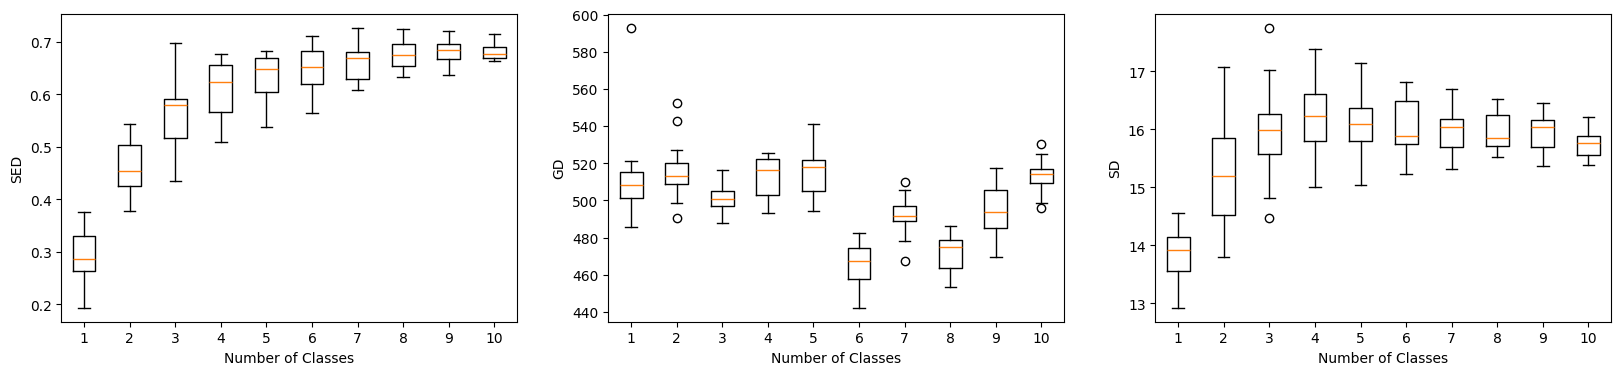

In [22]:
seds = []
gds = []
stds = []
for _ in range(20):
    sed,gd,std = run_experiment(test_activations, y_test, num_classes=10, num_images=100)
    seds.append(sed)
    gds.append(gd)
    stds.append(std)

transposed_results_sed = list(map(list, zip(*seds)))
transposed_results_gd = list(map(list, zip(*gds)))
transposed_results_std = list(map(list, zip(*stds)))

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].boxplot(transposed_results_sed)
axs[0].set_xlabel('Number of Classes')
axs[0].set_ylabel('SED')
axs[1].boxplot(transposed_results_gd)
axs[1].set_xlabel('Number of Classes')
axs[1].set_ylabel('GD')
axs[2].boxplot(transposed_results_std)
axs[2].set_xlabel('Number of Classes')
axs[2].set_ylabel('SD')
plt.show()